In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest            
from sklearn.neighbors import LocalOutlierFactor        
from sklearn.svm import OneClassSVM                      
from scipy.spatial.distance import mahalanobis 
from scipy.stats import chi2 
from pandas.plotting import parallel_coordinates  
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from pyod.models.gmm import GMM

In [2]:
df = pd.read_csv('yeast.csv')
print(df.head())

    mcg   gvh   alm   mit  erl  pox   vac   nuc name
0  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22  MIT
1  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22  MIT
2  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22  MIT
3  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22  NUC
4  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22  MIT


# Exploratory Data Analysis

First of all, I will check all the column, as well as their type. I also check if there's any missing values or not, so I can see if I must use imputation or not

In [3]:
print("Data Info:")
print(df.info())

Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     1484 non-null   float64
 1   gvh     1484 non-null   float64
 2   alm     1484 non-null   float64
 3   mit     1484 non-null   float64
 4   erl     1484 non-null   float64
 5   pox     1484 non-null   float64
 6   vac     1484 non-null   float64
 7   nuc     1484 non-null   float64
 8   name    1484 non-null   str    
dtypes: float64(8), str(1)
memory usage: 104.5 KB
None


Summarize the dataset for all numerical values:

In [4]:
print("Summary statistics:")
print(df.describe())

Summary statistics:
               mcg          gvh          alm          mit          erl  \
count  1484.000000  1484.000000  1484.000000  1484.000000  1484.000000   
mean      0.500121     0.499933     0.500034     0.261186     0.504717   
std       0.137299     0.123924     0.086670     0.137098     0.048351   
min       0.110000     0.130000     0.210000     0.000000     0.500000   
25%       0.410000     0.420000     0.460000     0.170000     0.500000   
50%       0.490000     0.490000     0.510000     0.220000     0.500000   
75%       0.580000     0.570000     0.550000     0.320000     0.500000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               pox          vac          nuc  
count  1484.000000  1484.000000  1484.000000  
mean      0.007500     0.499885     0.276199  
std       0.075683     0.057797     0.106491  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.480000     0.220000  
50%       0.000000     0.510000

Drop the label column for further analysis

In [5]:
df_main = df.drop(columns=['name'])
df_main.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22


Visualization of the yeast dataset:

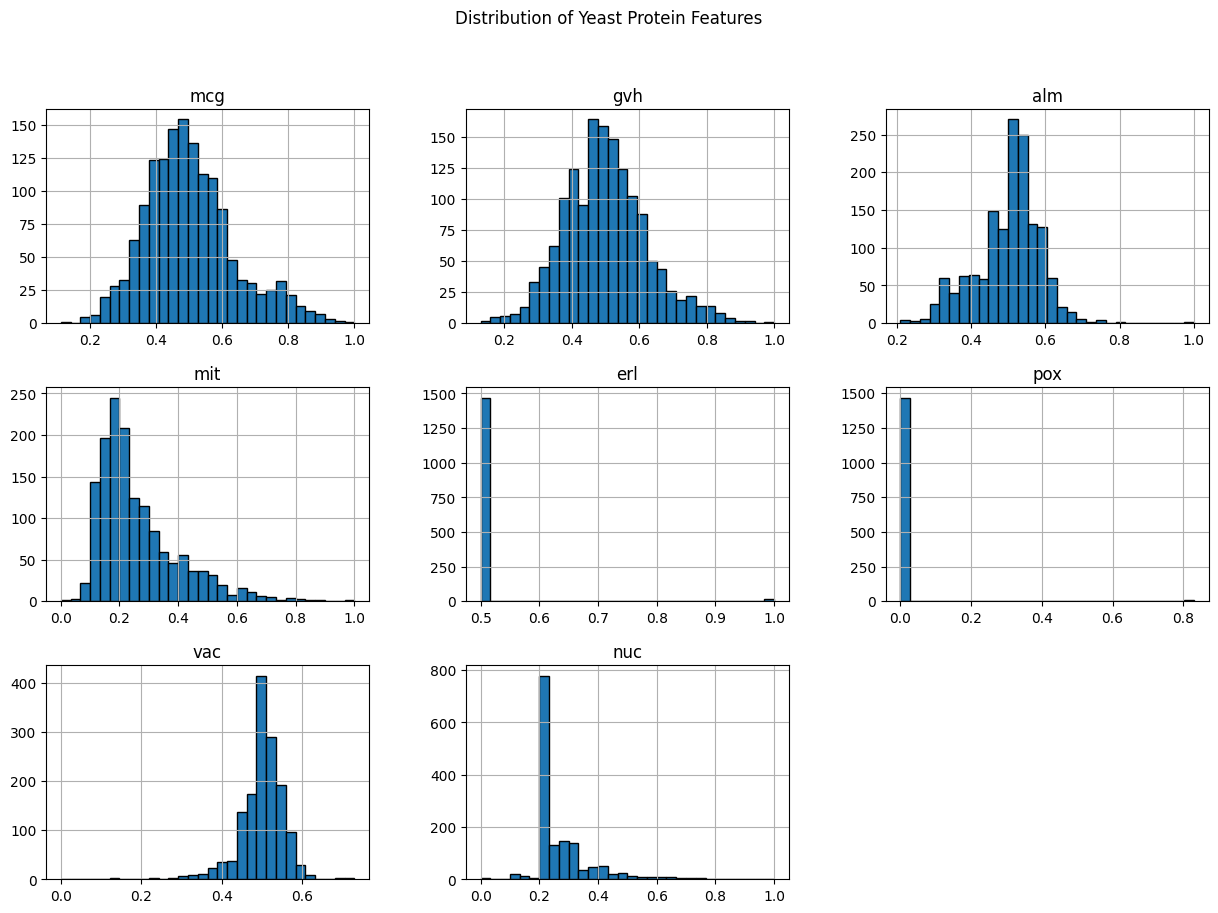

In [6]:
df_main.hist(bins=30, figsize=(15, 10), layout=(3, 3), edgecolor='black')
plt.suptitle('Distribution of Yeast Protein Features')
plt.show()

giai thich cai gi day....

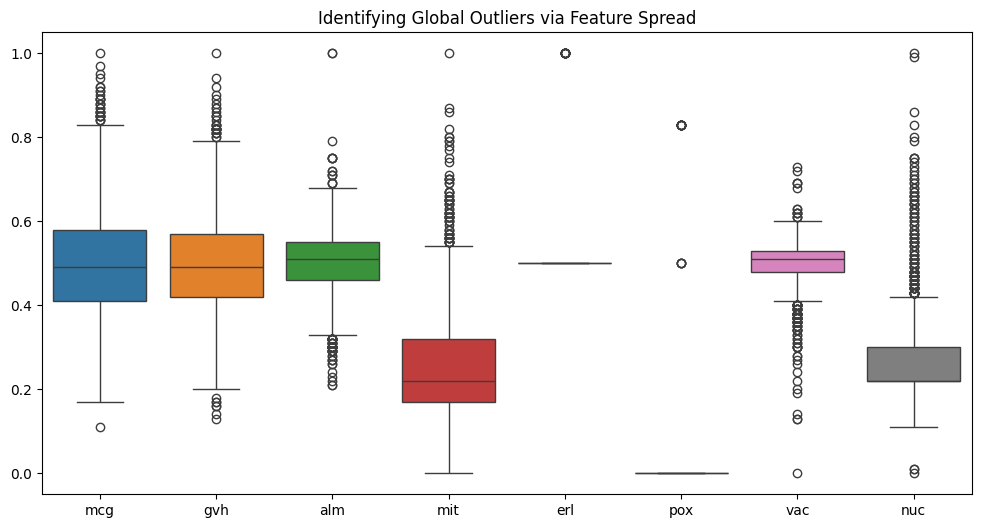

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_main)
plt.title('Identifying Global Outliers via Feature Spread')
plt.show()

giai thich cai gi day...

# Correlation Matrices

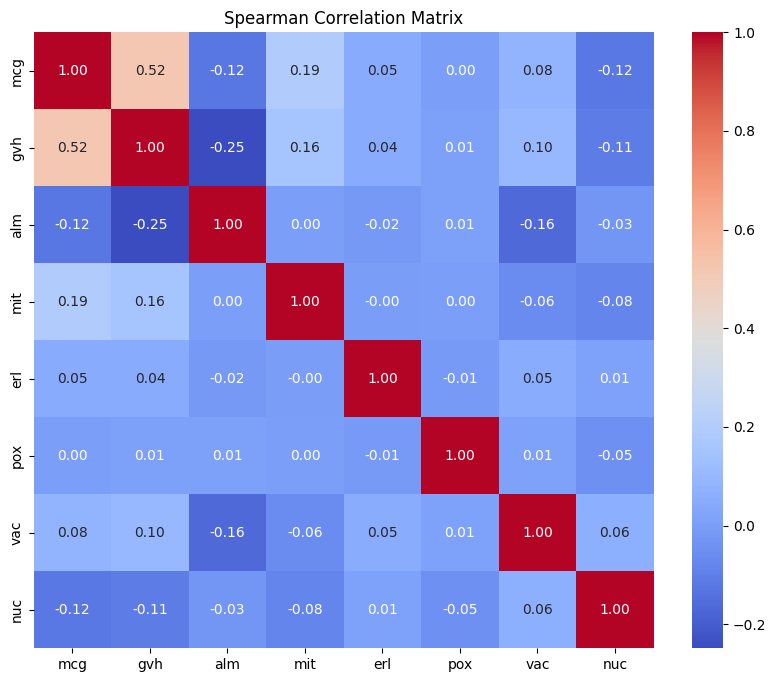

In [8]:
spearman_corr = df_main.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Matrix")
plt.show()

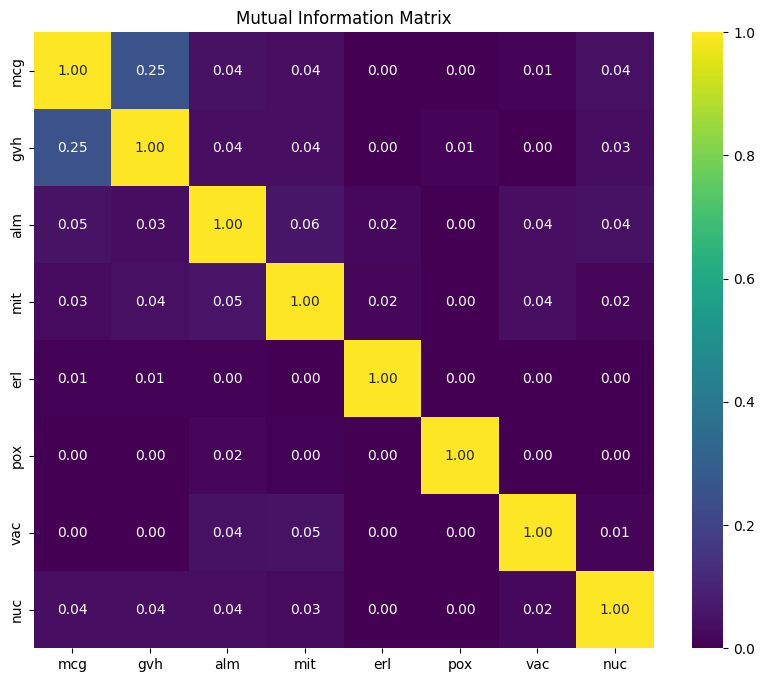

In [9]:
def mi_matrix(df):
    cols = df.columns
    n = len(cols)
    matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)
    
    for i in range(n):
        for j in range(n):
            if i == j:
                matrix.iloc[i, j] = 1.0 
            else:
                mi = mutual_info_regression(df[[cols[i]]], df.iloc[:, j], random_state=42)
                matrix.iloc[i, j] = mi[0]
    return matrix

mi_df = mi_matrix(df_main)
plt.figure(figsize=(10, 8))
sns.heatmap(mi_df, annot=True, cmap='viridis',fmt=".2f")
plt.title("Mutual Information Matrix")
plt.show()

As you can see from these 2 matrices, all the features are independant, therefore applying PCA would be a bad idea because we will lose a lot of information

# Anomaly Detection


Since this data is multivariate, I will not choose univariate technique like Z-score, IQR.... because they evaluate each feature independently and can't capture relationships between variables. 

For that reason, after searching the whole Internet, I will test out five multivariate models to compare their performance, and find out which one is the best for this dataset.

- Isolation Forest 

- Mahalanobis Distance 

- Local Outlier Factor 

- Gaussian Mixture 

- One-Class SVM 


But before that, I will scale the data using Standard Scaler to make sure that all features contribute equally to my analysis. 

- LOF and One-Class SVM require scaled data because they rely on distance calculations to determine neighborhood structure and decision boundaries. Without scaling, features with larger magnitudes would dominate these computations and affect the results. Gaussian Mixture also usually needs scaled data because it uses distance and data spread to find clusters.

- Isolation Forest are less sensitive to feature scaling because Isolation Forest isolates observations using random feature splits rather than distance measures, and Mahalanobis Distance does not require feature scaling because it inherently accounts for differences in feature scale and correlation through the inverse covariance matrix.  

- But I will apply the scaled data for all the methods for a fair comparison (I will use a Centroid ratio metric, which includes Euclidean distance, so the unscaled data will behave differently than scaled data), I will also test the unscaled data to IF and MD to better understand how scaling affects the results and to ensure a more thorough comparison.

In [10]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_main)
df_scaled = pd.DataFrame(df_scaled, columns=df_main.columns)
df_scaled.head()    

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.581981,0.888481,-0.346645,-0.957203,-0.09759,-0.099131,-0.344175,-0.527919
1,-0.510891,1.372811,-0.231226,0.064312,-0.09759,-0.099131,0.521219,-0.527919
2,1.019130,0.969203,-0.115808,-0.811272,-0.09759,-0.099131,0.521219,-0.527919
3,0.581981,-0.483786,0.807542,-0.957203,-0.09759,-0.099131,0.694298,-0.527919
4,-0.583749,-0.483786,-0.231226,2.034375,-0.09759,-0.099131,-0.344175,-0.527919


## Isolation Forest

In [11]:
df_if = df_scaled.copy()
iso_forest = IsolationForest(random_state=42) 
# I'm using all default parameters from scikit-learn IF because I want to keep it fair between methods

iso_forest.fit(df_if)
print("Isolation Forest Anomaly Counts:")
df_if['anomaly'] = iso_forest.predict(df_if)
print(df_if['anomaly'].value_counts())


Isolation Forest Anomaly Counts:
anomaly
 1    1385
-1      99
Name: count, dtype: int64


In [12]:
# just testing to prove my point in no scaling in IF
df_if_2 = df_main.copy()
iso_forest = IsolationForest(random_state=42) 

iso_forest.fit(df_if_2)
print("IF Without Scaling Anomaly Counts:")
df_if_2['anomaly'] = iso_forest.predict(df_if_2)
print(df_if_2['anomaly'].value_counts())

IF Without Scaling Anomaly Counts:
anomaly
 1    1385
-1      99
Name: count, dtype: int64


In [13]:
if (df_if['anomaly'] == df_if_2['anomaly']).all():
    print("They match!")
else:
    print("They don't match!")

# As you can see, scaling the data doesn't actually change anything.

They match!


I really wish I can do PCA to reduce the dimension of the data and visualize the learned frontier. But it's not possible with the dataset I have due to feature independance. So I will visualize the anomalies using parallel coordinates.

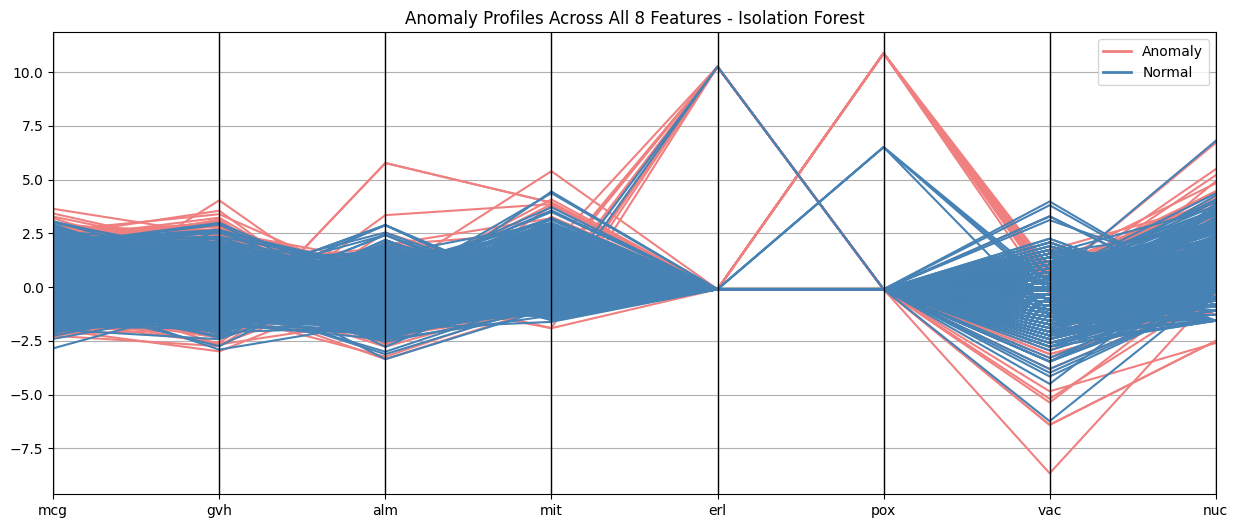

In [14]:
df_plot_sorted = df_if.sort_values(by='anomaly')
plt.figure(figsize=(15, 6))

parallel_coordinates(df_plot_sorted, 'anomaly', 
                     color=['lightcoral', 'steelblue'])

plt.title('Anomaly Profiles Across All 8 Features - Isolation Forest')
plt.xticks(rotation=0)

custom_lines = [Line2D([0], [0], color='lightcoral', lw=2),
                Line2D([0], [0], color='steelblue', lw=2)]
plt.legend(custom_lines, ['Anomaly', 'Normal'])
plt.show()

As we can see from the graph, pox and vac are the primary discriminators. A line that isolates by spiking to ~6 in pox, or dropping below -5 in vac is a high-priority anomaly. 

Features alm, mit and nuc shows some seperation, but not as distinct as pox and nuc. As we can see the red lines stay closer to the blue lines, so in my opinion, the IF needs more splits to seperate the anomaly.

Features mcg and gvh play a weak discriminatory role. Although the red lines are either above or below the normal distribution, we can't tell the difference between the two by just look at those two features, and we still need other features to make a decision. 

In feature erl, although most data is pinned at 0, there is a second spike at ~10. So erl is weak to seperate anomaly from normal distribution too. 

For those reasons, Isolation Forest is an effective (somehow) baseline. However, its performance is less effective for subtle anomalies in features like mcg, gvh or erl. We can do hyperparameter tuning to find the best parameters to fix this problem.

## Mahalanobis  Distance

In [15]:
df_md = df_scaled.copy()
mean_vec = df_md.mean().values
cov_matrix = np.cov(df_md.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

df_md['mahalanobis'] = df_md.apply(lambda row: mahalanobis(row.values, mean_vec, inv_cov_matrix), axis=1)
p_val = 0.975  
# => the rest 2.5% are counted as anomalies. I looked up on mahalanobis distance online and I saw people set to 97.5%
# After reading for a while, 97.5 is great because if we set to 95, more points flagged as anomalies, risk of false positives. 
# And if we set to 99, we will miss more true anomalies.

threshold = np.sqrt(chi2.ppf(p_val, df=df_md.shape[1]))
df_md['anomaly'] = np.where(df_md['mahalanobis'] > threshold, -1, 1)

print("Mahalanobis Distance Anomaly Counts:")
print(df_md['anomaly'].value_counts())

Mahalanobis Distance Anomaly Counts:
anomaly
 1    1415
-1      69
Name: count, dtype: int64


In [16]:
df_md_2 = df_main.copy() #test on unscaled data
mean_vec = df_md_2.mean().values
cov_matrix = np.cov(df_md_2.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

df_md_2['mahalanobis'] = df_md_2.apply(lambda row: mahalanobis(row.values, mean_vec, inv_cov_matrix), axis=1)
p_val = 0.975 


threshold = np.sqrt(chi2.ppf(p_val, df=df_md_2.shape[1]))
df_md_2['anomaly'] = np.where(df_md_2['mahalanobis'] > threshold, -1, 1)

print("Mahalanobis Distance Anomaly Counts:")
print(df_md_2['anomaly'].value_counts())

Mahalanobis Distance Anomaly Counts:
anomaly
 1    1415
-1      69
Name: count, dtype: int64


In [17]:
if (df_md['anomaly'] == df_md_2['anomaly']).all():
    print("They match!")
else:
    print("They don't match!")

# As you can see, scaling the data doesn't actually change anything (once again)

They match!


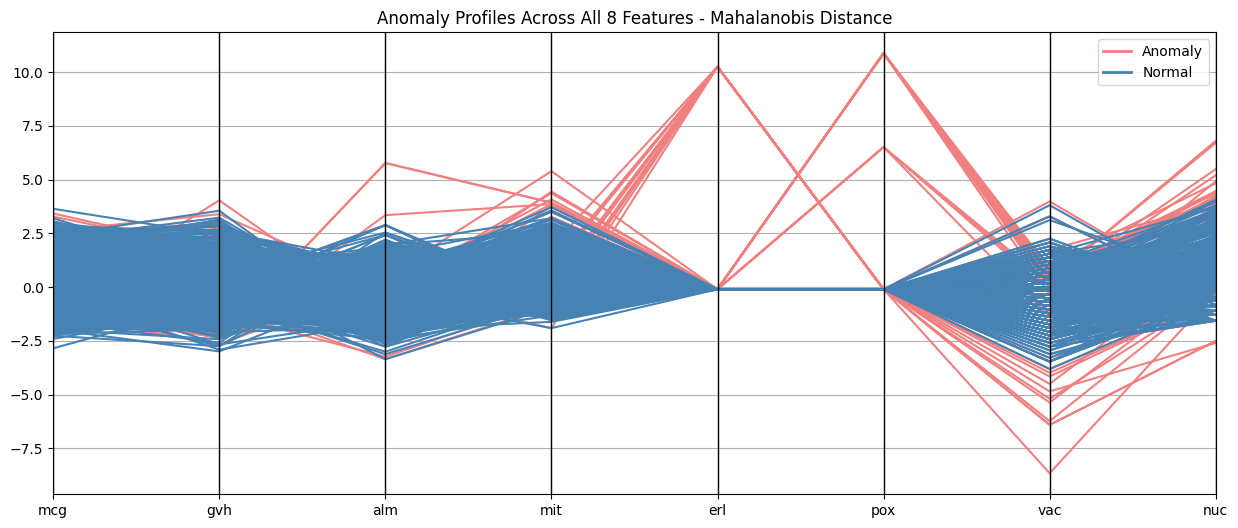

In [18]:
df_plot_sorted = df_md.drop(columns=['mahalanobis']).sort_values(by='anomaly')
plt.figure(figsize=(15, 6))

parallel_coordinates(df_plot_sorted, 'anomaly', 
                     color=['lightcoral', 'steelblue'])

plt.title('Anomaly Profiles Across All 8 Features - Mahalanobis Distance')
plt.xticks(rotation=0)

custom_lines = [Line2D([0], [0], color='lightcoral', lw=2),
                Line2D([0], [0], color='steelblue', lw=2)]
plt.legend(custom_lines, ['Anomaly', 'Normal'])
plt.show()

Just like Isolation Forest, we can see that erl, pox and vac are the primary discriminators here, when a value is significantly higher than 0 in erl and pox, or a value is significantly lower than 0 in vac, it is flagged as anomaly.

Although the red line at alm, mit and nuc seperate from the blue cluster, it's not as clear as the primary discriminators. 
* For alm and mit: The red lines seperate from the blue cluster, peaking at of ~6 and ~5 respectively, but they still run relatively close to the upper bounds of the normal data. 
* For nuc: The anomalies are identified under ~-2 or above ~3, but there are some red lines that are close to the blue lines.

Features mcg and gvh continue to play a weak discriminator role, when the red and blue lines almost entirely overlap there. These features likely contribute very little to the anomaly score of their own.

For those reasons, I believe that Mahalanobis Distance is an effective method for anomaly detection.

## Local Outlier Factor

In [19]:
df_lof = df_scaled.copy()
lof = LocalOutlierFactor()
df_lof['anomaly'] = lof.fit_predict(df_lof)
print("LOF Anomaly Counts:")
print(df_lof['anomaly'].value_counts())

LOF Anomaly Counts:
anomaly
 1    1403
-1      81
Name: count, dtype: int64


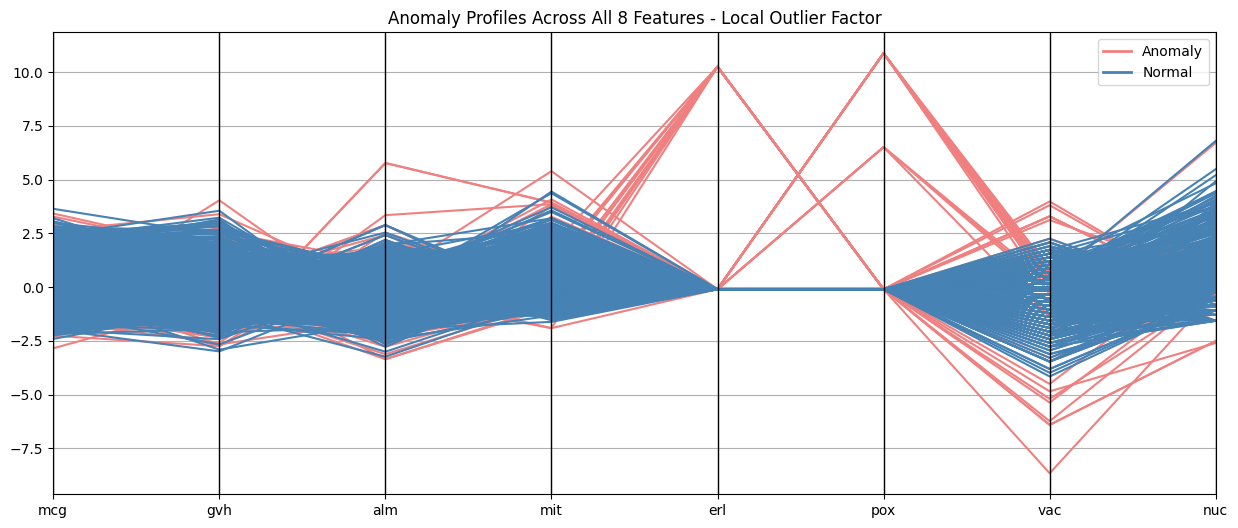

In [20]:
df_plot_sorted = df_lof.sort_values(by='anomaly')
plt.figure(figsize=(15, 6))

parallel_coordinates(df_plot_sorted, 'anomaly', 
                     color=['lightcoral', 'steelblue'])

plt.title('Anomaly Profiles Across All 8 Features - Local Outlier Factor')
plt.xticks(rotation=0)

custom_lines = [Line2D([0], [0], color='lightcoral', lw=2),
                Line2D([0], [0], color='steelblue', lw=2)]
plt.legend(custom_lines, ['Anomaly', 'Normal'])
plt.show()

Just like MD, we can see that erl, pox, and vac are the primary discriminators here. When a value is significantly higher than 0 in erl and pox, or a value is significantly higher than ~3 and lower than ~-3 in vac, it is consistently flagged as an anomaly.

Secondary discriminators like alm, mit, and nuc show some separation, but the distinction is not as absolute as the primary group. 
* For alm and mit: The red lines seperate from the blue cluster, peaking at of ~6 and ~5 respectively, but they still run relatively close to the upper bounds of the normal data. 
* For nuc: The anomalies show a tendency to drop below ~-2.5, but there is still some proximity to the blue lines.

Once again, features mcg and gvh continue to play a weak discriminator role. The red and blue lines almost entirely overlap in these columns. We cannot tell the difference between the two classes by looking at these features alone, showing that they contribute very little to the anomaly score in this model.

For those reasons, I believe Local Outlier Factor is an effective method for this dataset.

## Gaussian Mixture 

In [21]:
df_gmm = df_scaled.copy()
gmm_detector = GMM()
gmm_detector.fit(df_gmm)
df_gmm['anomaly'] = gmm_detector.labels_
print("Gaussian Mixture Anomaly Counts:")
print(df_gmm['anomaly'].value_counts())

Gaussian Mixture Anomaly Counts:
anomaly
0    1335
1     149
Name: count, dtype: int64


In [22]:
df_gmm['anomaly'] = df_gmm['anomaly'].replace({0: 1, 1: -1}) # change the label to match other models
df_gmm.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,anomaly
0,0.581981,0.888481,-0.346645,-0.957203,-0.09759,-0.099131,-0.344175,-0.527919,1
1,-0.510891,1.372811,-0.231226,0.064312,-0.09759,-0.099131,0.521219,-0.527919,1
2,1.019130,0.969203,-0.115808,-0.811272,-0.09759,-0.099131,0.521219,-0.527919,1
3,0.581981,-0.483786,0.807542,-0.957203,-0.09759,-0.099131,0.694298,-0.527919,1
4,-0.583749,-0.483786,-0.231226,2.034375,-0.09759,-0.099131,-0.344175,-0.527919,1


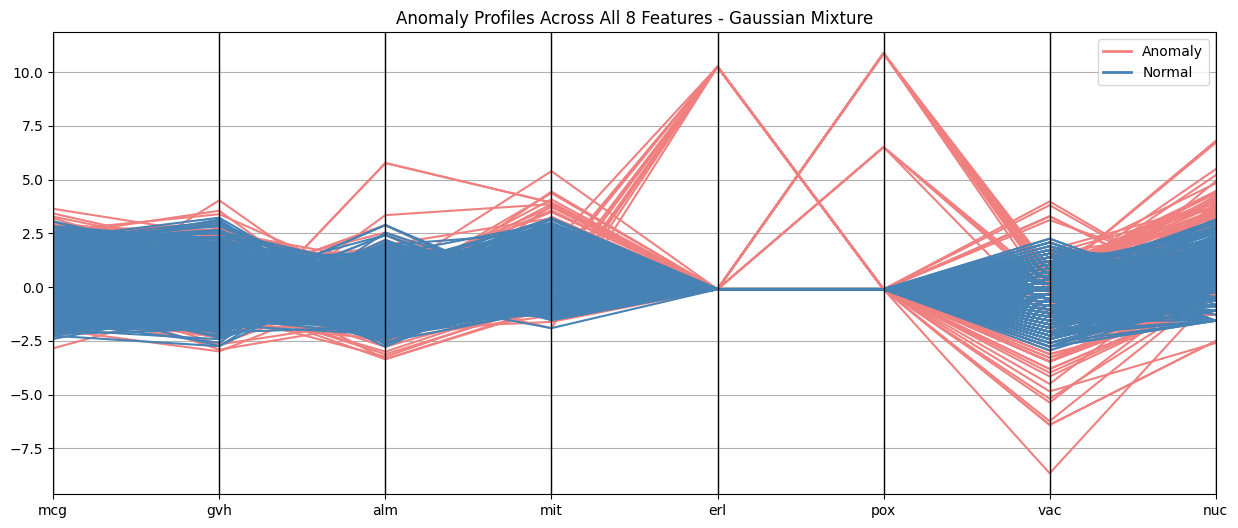

In [23]:
df_plot_sorted = df_gmm.sort_values(by='anomaly')
plt.figure(figsize=(15, 6))

parallel_coordinates(df_plot_sorted, 'anomaly', 
                     color=['lightcoral', 'steelblue'])

plt.title('Anomaly Profiles Across All 8 Features - Gaussian Mixture')
plt.xticks(rotation=0)

custom_lines = [Line2D([0], [0], color='lightcoral', lw=2),
                Line2D([0], [0], color='steelblue', lw=2)]
plt.legend(custom_lines, ['Anomaly', 'Normal'])
plt.show()

Just like Mahalanobis Distance, we can see that erl, pox, and vac are the primary discriminators here. When a value is significantly higher than 0 in erl and pox, or a value is significantly lower than ~-3 in vac or above ~2.3, it is flagged as an anomaly.

Secondary discriminators like alm, mit, and nuc show some separation, but the distinction is not as absolute as the primary group. 
* For alm and mit, the red lines separate from the blue cluster, peaking at ~6 and ~5 respectively, but they still run close to the upper bounds of the normal data. 
* For nuc, the anomalies show a tendency to rise above 3 or drop below -2.5, but there is still some proximity to the blue lines.

Once again (again, as expected), features mcg and gvh continue to play a weak discriminator role. The red and blue lines continue to overlap in these columns. We cannot tell the difference (again?) between the two classes by looking at these features alone, showing they contribute very little to the anomaly score in this model.

Gaussian Mixture catches more anomalies than all the methods mentioned. To see if it is a truly effective method for this dataset, I need to do evaluation with my metrics. But so far, I think this method is okay-ish for this dataset.

## One-Class SVM

In [24]:
df_ocsvm = df_scaled.copy()
ocsvm = OneClassSVM()
df_ocsvm['anomaly'] = ocsvm.fit_predict(df_ocsvm)

print("One-Class SVM Anomaly Counts:")
print(df_ocsvm['anomaly'].value_counts())

One-Class SVM Anomaly Counts:
anomaly
 1    743
-1    741
Name: count, dtype: int64


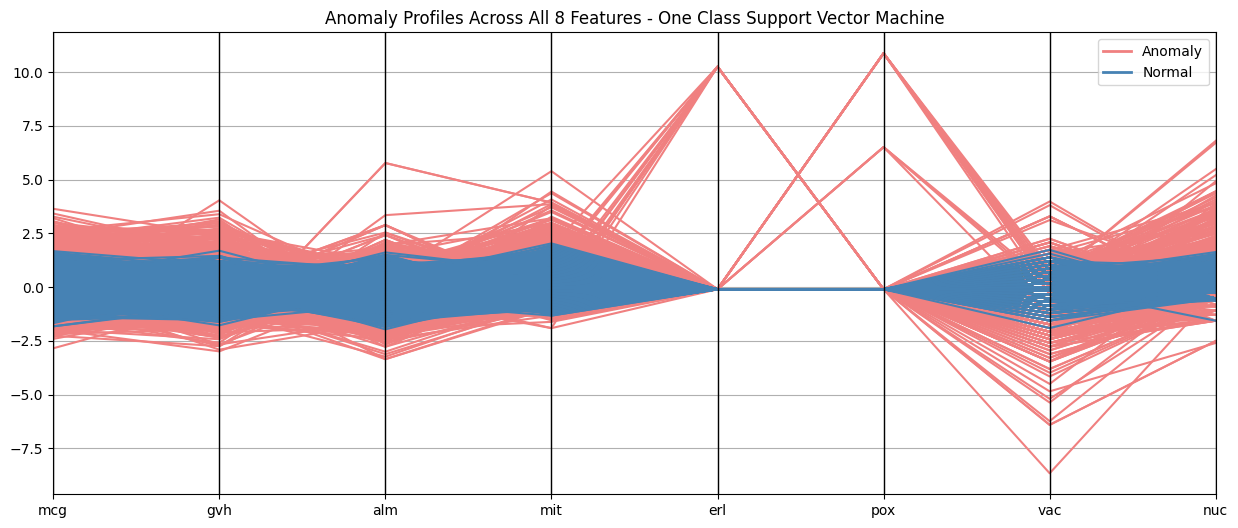

In [25]:
df_plot_sorted = df_ocsvm.sort_values(by='anomaly')
plt.figure(figsize=(15, 6))

parallel_coordinates(df_plot_sorted, 'anomaly', 
                     color=['lightcoral', 'steelblue'])

plt.title('Anomaly Profiles Across All 8 Features - One Class Support Vector Machine')
plt.xticks(rotation=0)

custom_lines = [Line2D([0], [0], color='lightcoral', lw=2),
                Line2D([0], [0], color='steelblue', lw=2)]
plt.legend(custom_lines, ['Anomaly', 'Normal'])
plt.show()

To begin with, right of the bat, the number of normal value and anomaly are almost the same. This shows a bad sign already. 

Just like the previous models, erl, pox, and vac remain the primary discriminators in this One Class Support Vector Machine profile. A value significantly higher than ~0 in erl and pox, or a value dropping below ~-5 in vac, is flagged as an anomaly.

For the rest of the features, the graph shows a sandwich-like structure where the red lines surround the blue cluster from both above and below. In these columns, the red lines are almost eating up the blue lines, which shows that this model captures a lot of false anomalies. This lack of clearance in those features shows that this model cannot effectively define a boundary for normal behavior.

For those reasons, I believe that One Class Support Vector Machine is not an effective method for this dataset. 

# Comparision Between All Models

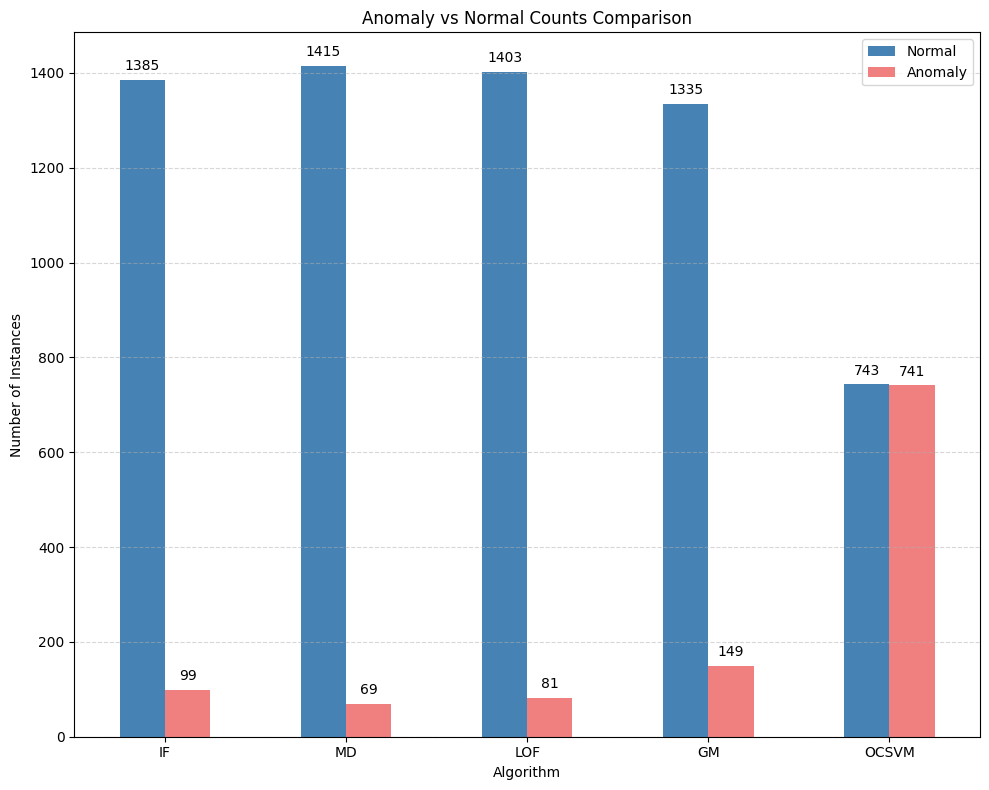

In [26]:
models = {
    'IF': df_if,
    'MD': df_md,
    'LOF': df_lof,
    'GM': df_gmm,
    'OCSVM': df_ocsvm
}

summary_data = []

for name, df in models.items():
    counts = df['anomaly'].value_counts()
    summary_data.append({
        'Model': name,
        'Normal': counts.get(1, 0),
        'Anomaly': counts.get(-1, 0)
    })

plot_df = pd.DataFrame(summary_data).set_index('Model')
ax = plot_df.plot(kind='bar', figsize=(10, 8), color=['steelblue', 'lightcoral'])


plt.title('Anomaly vs Normal Counts Comparison')
plt.ylabel('Number of Instances')
plt.xlabel('Algorithm')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

The graph shows significantly in how aggressively they flag data points:

* OCSVM: 741 anomalies

* GM: 149 anomalies

* IF: 99 anomalies

* LOF: 81 anomalies

* MD: 69 anomalies

MD, LOF and IF are the most conservative. MD identifies the fewest anomalies, followed closely by LOF and IF. They maintain a heavy skew toward normal instances, which generally ranges between 1385 and 1415.

GM catches more anomalies than the methods mentioned earlier, but they are still a small group compared to the 1,335 normal instances.

OCSVM stands alone with a nearly 1:1 ratio, flagging 741 anomalies and 743 normal instances. It labels nearly half the dataset as anomalies, which highly contrasts with the other four methods.

Furthermore, to find the best model, I will use these metrics: 
- Silhouette score

- Centroid Ratio

## Silhouette Score

Silhouette score calculates how similar a data point is to its own group compared to the other group

In [27]:
features = ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']
sil_scores = {}
for name, df in models.items():
    score = silhouette_score(df[features], df['anomaly'])
    sil_scores[name] = score

sorted_models = sorted(sil_scores.items(), key=lambda x: x[1], reverse=True)
print("---- Ranked Silhouette Scores ----")
print(f"{'Rank':<5} | {'Model':<8} | {'Silhouette Score':<15}")
print("-" * 40)

for rank, (name, score) in enumerate(sorted_models, 1):
    print(f"{rank:<5} | {name:<8} | {score:<15.4f}")

---- Ranked Silhouette Scores ----
Rank  | Model    | Silhouette Score
----------------------------------------
1     | MD       | 0.5775         
2     | LOF      | 0.5211         
3     | IF       | 0.4894         
4     | GM       | 0.4461         
5     | OCSVM    | 0.0925         


## Centroid Ratio

Centroid ratio calculates the ratio of (Avg Anomaly-to-Center distance) / (Avg Normal-to-Center distance)

In [28]:
def calculate_centroid_ratio(df, features):
    normal = df[df['anomaly'] == 1][features].values
    anomalies = df[df['anomaly'] == -1][features].values

    center = normal.mean(axis=0).reshape(1, -1)

    # calculate the average distance between anomalies and the center, use Euclidean distance by default
    avg_separation = np.mean(cdist(anomalies, center, metric='euclidean'))

    # calculate the average distance between normal points and it's own center
    avg_compactness = np.mean(cdist(normal, center, metric='euclidean'))
    ratio = avg_separation / avg_compactness
    return ratio, avg_separation, avg_compactness

# calculate for all models
centroid_ratios = {}
centroid_values = {}

for name, df in models.items():
    ratio, avg_sep, avg_compact = calculate_centroid_ratio(df, features)
    centroid_ratios[name] = ratio
    centroid_values[name] = (avg_sep, avg_compact)

sorted_models = sorted(centroid_ratios.items(), key=lambda x: x[1], reverse=True)

print("---- Ranked Centroid Ratios ----")
print(f"{'Rank':<5} | {'Model':<8} | {'Ratio':<8} | {'Avg Anomaly Dist':<15} | {'Normal Value Spread':<15}")
print("-" * 70)

for rank, (name, ratio) in enumerate(sorted_models, 1):
    avg_sep, avg_compact = centroid_values[name]
    print(f"{rank:<5} | {name:<8} | {ratio:<8.2f} | {avg_sep:<15.2f} | {avg_compact:<15.2f}")


---- Ranked Centroid Ratios ----
Rank  | Model    | Ratio    | Avg Anomaly Dist | Normal Value Spread
----------------------------------------------------------------------
1     | MD       | 3.55     | 7.57            | 2.14           
2     | LOF      | 3.07     | 6.60            | 2.15           
3     | IF       | 2.92     | 6.18            | 2.12           
4     | GM       | 2.78     | 5.62            | 2.02           
5     | OCSVM    | 2.23     | 3.30            | 1.48           


it is clear that MD is the most effective model for this dataset with a top rank across both metrics. These scores shows that MD has the cleanest separation and pushes anomalies the furthest from the normal data. It is followed by LOF and IF, which maintain solid performance.

My hypothesis on GM is okay-ish is correct while it's ranked at the 4th place in both metrics. While it identifies a distinct set of 149 anomalies, its lower average anomaly distance of 5.62 shows that the separation is less clear than the top three models.

And about OCSVM, well, with a 1:1 ratio, it's obviously the worst methods compared to the others. It's Silhouette Score is 0.0925, a near zero score, and a 2.23 ratio show that the anomalies are heavy overlap with the normal cluster. It cannot push the anomalies far enough away from the normal cluster to create a distinct gap.

# Conclusion

In this notebook, I successfully implemented five different models to detect anomalies on the Yeast dataset. Under default parameters, Mahalanobis Distance proved to be the most effective method for this task, meanwhile One-Class Support Vector Machine  was the least effective, with a nearly 1:1 ratio of normal to anomalies values.

Future work will include hyperparameter tuning for each model and the implementation of deep learning methods to improve anomaly detection effectiveness. 